In [1]:
#@title Run this cell and then comment and restart runtime

! git clone https://github.com/bemc22/AdaHSI
%cd AdaHSI


%cd third_party/cython/
!python setup.py install --user
%cd ../..

In [2]:
%cd AdaHSI

/content/AdaHSI


In [3]:
#@title Set device
import torch 

if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [11]:
#@title Load model

import os 

m_value = 32   # Amount of SLIC superpixels
s_value = 484  # Amount of deep superpixels
num_channels = 162
dataset  = "wdc"    

model_path = f"model_best_wdc_pretrain_v2_n=512.tar"
model_path = os.path.join("checkpoints", model_path)


from ada_hsi.models import SPCApative
features=[16, 32, 64, 128]

model_name = 'spixelnet'


model_args = dict(
    n_channels= num_channels,
)

if model_name == 'unet':
  model_args['features'] = features


model = SPCApative(model_args, model_name=model_name, concat_sideinfo=True, pos_encod=False, slic=True)
model.load_state_dict(torch.load(model_path, map_location=DEVICE)['state_dict'])
model.eval()


Sideinformation with multiplicative operation


SPCApative(
  (model): SpixelNet(
    (conv0a): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (conv0b): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (conv1a): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (conv1b): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

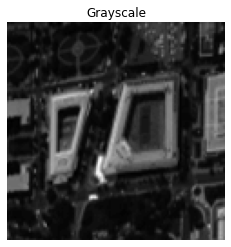

In [12]:
#@title Load and Visualize Data: Upload a image.png file in the AdaHSI folder
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt

RGB = [30, 0, 2]


data_path = "image.png"
grayscale = cv2.imread(data_path, cv2.IMREAD_GRAYSCALE)[..., None]
grayscale = grayscale.astype('float32') / 255.0

plt.imshow(grayscale[..., 0], cmap='gray')
plt.title('Grayscale')
plt.axis("off")

plt.show()

total number superpixels: 478


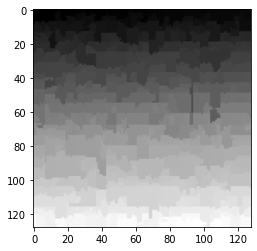

In [20]:
#@title Inference

import math
import numpy as np 

from ada_hsi.train import get_decimation_matrix, spc_estimation
from ada_hsi.spixelnet.train_util import init_spixel_grid
from torchvision import transforms

import sys
sys.path.append('./third_party/cython')
from connectivity import enforce_connectivity


SIZE = 128
BATCH_SIZE = 1

# downsize = math.ceil(SIZE / np.sqrt(s_value))
downsize = 6

args = dict(
    img_height = SIZE,
    img_width =  SIZE,
    batch_size = BATCH_SIZE,
    downsize = downsize,
)


resize = transforms.Resize(SIZE)


_input = torch.tensor(grayscale).permute(2, 0, 1).unsqueeze(0).float()
_input = resize(_input)


prob = model(_input.to(DEVICE))


spixelID, _ = init_spixel_grid(args)
superpixels = get_decimation_matrix(prob, spixelID)
superpixels = superpixels.cpu().numpy()[0]
superpixels = superpixels.astype(np.int64)

segment_size = (SIZE * SIZE) / (int(s_value) * 1.0)
min_size = int(0.35 * segment_size)
max_size =  int(3 * segment_size)
superpixels = enforce_connectivity(superpixels[None, :, :], min_size, max_size)

print("total number superpixels:", np.max(superpixels))

plt.imshow(superpixels[0], cmap='gray')
plt.show()


In [21]:
#@title Save superpixels

save_path = os.path.join("..", "superpixels.mat")
sio.savemat(save_path, {"D": superpixels[0]})
print("superpixels saved at ", save_path)

superpixels saved at  ../superpixels.mat
